In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#imports
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt 
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from IPython.display import display

In [3]:
def plot_return(strat):
    path = r'C:\Users\arizonazhang\OneDrive - hkaift\research\capflow'
    return_df = pd.read_csv(path+"\portfolios\portfolio_sort_{}.csv".format(strat))
    fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4))
    ls = [5, 10, 30]
    for i in range(3):
        monthly_df = return_df[(return_df.n==ls[i])&(return_df.m==ls[i])]
        monthly_df = monthly_df.pivot(index='date', columns=["factor_rank","mktcap_rank"], values="ret")
        annual_df = (monthly_df+1).cumprod().iloc[-1,:].pow(225/1733)-1
        annual_df.unstack(-2).plot.bar(colormap="Blues", ax=axes[i], title="{}-day inflow v.s. {}-day return".format(ls[i],ls[i]))
    fig.suptitle("Annual Return of {} Inflow Factor 5-layer Portfolios".format(strat))

In [3]:
# plot functions for IC tables
def summary_table(name, strat):
    path = r'C:\Users\arizonazhang\OneDrive - hkaift\research\capflow'
    ls = []
    for n in [5, 10 ,30]:
        try:
            corr = pd.read_csv(path+name.format(n),index_col=0)
            for i in [5,10, 30]:
                col = "corr_" + str(i)
                means = [corr[col].rolling(5).mean()[i::5].mean() for i in range(5)]
                stds = [corr[col].rolling(5).mean()[i::5].std() for i in range(5)]
                irs = [means[i]/stds[i] for i in range(5)]
                means.sort()
                stds.sort()
                irs.sort()
                acf1 = sorted([corr[col].rolling(5).mean()[i::5].autocorr(lag=1) for i in range(5)])
                acf2 = sorted([corr[col].rolling(5).mean()[i::5].autocorr(lag=2) for i in range(5)])
                ls.append([n ,i, means[2], corr[col].median(), irs[2], stds[2], len(corr[(corr[col]>0)&(corr["p_"+str(i)]<0.05)])/len(corr), acf1[2], acf2[2]])
        except:
            print("Failed to fetch data.")
    df = pd.DataFrame(ls,columns = ["n-day inflow","m-day return","IC mean", "IC median","IR","std",">0(%)","acf (lag=1)","acf (lag=2)"])
    df = df.set_index(["n-day inflow","m-day return"])
    display(df.style.format('{:.4f}').set_caption("IC summary of the {} inflow factor".format(strat)))
    return(df)
def ic_summary_plot(table):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))
    table = table.reset_index()
    mean_table = table.pivot(index="m-day return", columns = "n-day inflow", values="IC mean")
    mean_table.plot.bar(title="Mean correlation", ax = axes[0])
    median_table = table.pivot(index="m-day return", columns = "n-day inflow", values="IC median")
    median_table.plot.bar(title="Median correlation", ax = axes[1])
    #ir_table = table.pivot(index="m-day return", columns = "n-day inflow", values="IR")
   # ir_table.plot.bar(title="IR", ax = axes[1,0])
    #pos_table = table.pivot(index="m-day return", columns = "n-day inflow", values=">0(%)")
    #pos_table.plot.bar(title="Percentage of >0", ax = axes[1,1])

In [5]:
path = r'C:\Users\arizonazhang\OneDrive - hkaift\research\capflow'
def plot_backtest(file, n):
    df = pd.read_csv(path + file, index_col = 0)
    df = df.set_index("date")
    df.index = pd.to_datetime(df.index)
    df.loc[df.strategy == "delta","strategy"] = "pure"
    fig,axes = plt.subplots(figsize = (20,5), nrows = 1, ncols = len(n))
    ls = []
    y = []
    for i in range(len(n)):
        cum_ret = df[df.n==n[i]].pivot(columns = "strategy", values = "M")
        cum_ret.plot(ax = axes[i], title = "Cumulative Return ({:d}-day inflow)".format(n[i]))
        ret = df[df.n==5*(i+1)].pivot(columns = "strategy", values = "net_ret")
        d = {}
        days = (cum_ret.index[-1] - cum_ret.index[0])/np.timedelta64(1, "D")
        d["annualized return"] = cum_ret.iloc[-1].pow(365/days)-1
        d["annualized vol"] = ret.std()*np.sqrt(25)
        d["sharpe ratio"] = d["annualized return"]/d["annualized vol"]
        drawdown = cum_ret/cum_ret.rolling(1500,min_periods=1).max()-1
        d["maximum drawdown"] = drawdown.min()
        d["t values"] = ret.mean()/ret.std()*np.sqrt(ret.shape[0])
        ls.append(d)
        yearly = (ret+1).groupby(ret.index.year).prod()-1
        y.append(yearly)
        quarterly = (ret+1).groupby([ret.index.year, ret.index.month])
    return y, ls

def summary_table2(ls):
    df1 = pd.DataFrame.from_dict(ls[0], orient="index")
    df2 = pd.DataFrame.from_dict(ls[1], orient="index")
    display(df1.style.format('{:.2%}').set_caption("Summary Table (5-day inflow)").background_gradient("Blues",axis=1))
    display(df2.style.format('{:.2%}').set_caption("Summary Table (10-day inflow)").background_gradient("Blues",axis=1))
    
def summary_tables3(y):
    display(y[0].style.format('{:.2%}').set_caption("Annual Returns (5-day inflow)").background_gradient("Blues",axis=1))
    display(y[1].style.format('{:.2%}').set_caption("Annual Returns (10-day inflow)").background_gradient("Blues",axis=1))
    
def plot_percentage():
    ls = []
    for i in [25, 50, 100]:
        df = pd.read_csv(path + r'\long_short\return_v2_{}.csv'.format(i), index_col = 0)
        df = df.set_index("date")
        df.index = pd.to_datetime(df.index)
        df.loc[df.strategy == "delta","strategy"] = "pure"
        ls.append(df[(df.n==10)&(df.strategy=="pure")].pivot(columns = "strategy", values = "M"))
    df_all = pd.concat(ls, axis =1)
    df_all.columns = ["2.5%","5%","10%"]
    df_all.plot(title='')

In [6]:
total_ret = lambda x: x.dropna()[-1]
annual_ret = lambda x: x.dropna()[-1]**(365/((x.index[-1] - x.index[0])/np.timedelta64(1, "D")))-1
vol = lambda x: x.dropna().std()*np.sqrt(25)
sharpe = lambda x: annual_ret(x)/vol(x)
mdd = lambda x: (x.dropna()/x.dropna().rolling(200, min_periods=1).max()-1).min()
tvalue = lambda x: x.dropna().mean()/x.dropna().std()*np.sqrt(len(x.dropna()))
ret_year = lambda x:(x.dropna()+1).groupby([x.dropna().index.year,x.dropna().index.month]).prod()-1

# Background
Following a study of southbound inflow through the stock connect system with respect to the overall market, we found that information contained in this factor helps us to time the general market effectively. Therefore, we would like to investigate the effect of southbound money inflow in relation to single stock returns and build a strategy to make use of the information.

There are **two possible explanation** for the southbound money information.
1. Mainland investors mainly use stock connect to invest in mainland companies that are listed in HKSE. As compared to foreign investors, they have the edge in obtaining more information and hence their trade movements could be valuable.
2. When mainland funds need to long a large amounts of a stock, the constant trade would result in a short-term momentum of the stock price, leaving opportunity to extract value.

# The Pure Inflow Factor

The inflow factor measures the amount of capital traded by mainland investors, i.e. the change in investor holdings in single stocks. We calculated this factor by multiplying the change of shares held by mainland investors multiplied by the proxy price of the stock, which is the average of open, high, low and close price. 

## Correlation Study

To understand its relationship with stock return, we computed the **Information Coefficient (IC)** of the 5-day, 10-day and 30-day inflow factor over time. 

The **calculation horizon** starts from 2017/03/20 to 2022/02/24 and the **stock universe** is all the stocks listed in stock connect.

Before calculation, we made the following **adjustments** to avoid outliers in our samples:
1. winsorize and standardize the factor values before computation
2. excludes stocks that have just been included in the stock connect in the past 60 trading days
3. excluded stocks that would be moved out from the stock connect in the past 60 trading days

Due to the **T+2 settlement mechanism**, the inflow information would only be known after 2 days. Hence, the return computed would start from 2 days after the actual inflow day. Return used in the investigation is calculated using the close price on T+2 and the close price on T+7, T+12 and T+32.

The table below summarize the results from the calculation. 
1. ">(%)" calculates the number of correlations that are greater than 0 and have a p-value smaller than 0.05
2. "acf (lag=k)" computes the autocorrelation of the correlation of the **non-overlapping correlation** time series
3. IC mean takes the median of five means calculated from the 5 non-overlapping correlation time series

In [7]:
table = summary_table("\correlations\correlation_{:d}d_v4.csv","pure")

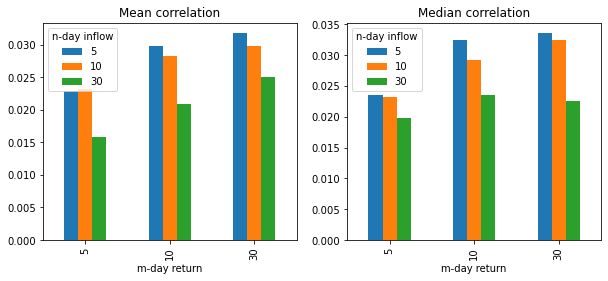

In [8]:
ic_summary_plot(table)

**Finding**: As we could see, IC pf 5- and 10-day inflow factor are around 0.02-0.03, which is above the threshold for effective factor. 5-day inflow has the highest IC with 5- to 30-day return and the correlation increases with the return horizon increases. However, the correlation increase slows down when return horizon increases from 10- to 30- days, which is likely due to alpha decay.

## Layer Portfolio Construction
To further investigate factor return, we constructed a 5-layer portfolio and computed portfolio return overtime. Calculation periods and stock universe are the same as above.

Annual return of the 5-layer portfolios tested on different time horizon are shown below. Stocks with the largest inflow belongs to group 5 while stocks with largest outflow belongs to group 1.

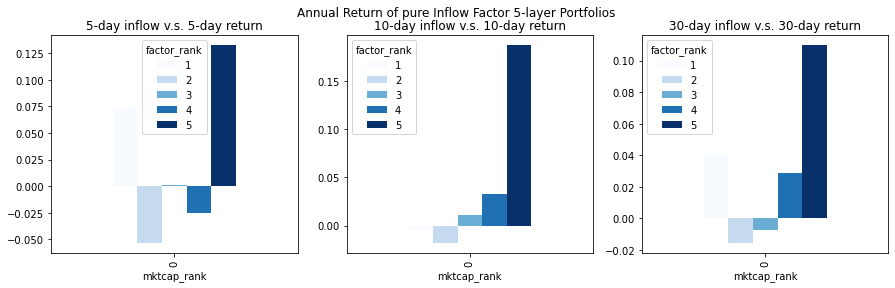

In [9]:
plot_return("pure")

**Finding**: To our surprise, portfolios in the two ends, i.e. the portfolio containing most inflow and the portfolio containing the most outflow outperform other groups. It seems like the porfolio in the middle contain much less information as compared to the end ones. Intuitively, stocks that are inactively traded are usually small-cap or not in the interest of mainland investors. Hence, there are two possible ways to improve the factor.
1. neutralize market cap influence of this factor. Since large-cap stocks are inevitably more actively traded, excluding market-cap influence might help us understand more about this factor.
2. study the factor on the stocks that have large inflow or outflow, i.e. distributed in the tails.

# Improvements

## Neutralization
In extracting market cap influence, we come up with the following two factors:

**1. neutralized factor ("neu")**

Neutralized factor is calculated as follows:

$Y_t = \theta_0 + \theta_1 Ln(MV)_t + neu_t$ where $Y_t$ denotes the inflow amount at time $t$

**2. absolute neutralized factor ("absneu")**

another model is proposed to extract market value exposure from the absolute amount of the inflow amount. The flow direction (i.e. the signs) is then multiplied back to the residual. Intuitively, large-cap stocks should have both large inflow and outflow.

$|Y_t| = \beta_0 + \beta_1 Ln(MV_t) + e_t$

$absneu_t = e_t \frac{Y_t}{|Y_t|}$

IC summaries of the two factors are shown below.

In [10]:
table = summary_table("\correlations\correlation_neu_{:d}d_v4.csv","neu")

In [11]:
table = summary_table("\correlations\correlation_absneu_{:d}d_v4.csv","absneu")

**Finding**: From the regression, we noticed that the goodness of fit for the second model is better than the first one (p-value all below 1.5% while p-value of first model have an average of 11%). This aligns with intuition since large-cap stocks could have very large inflow and outflow.

Regarding prediction power, the IC of the absneu factor is higher than the neu factor but the means are all below 2%. The two factors do not show better prediction power after neutralizing. The 5-layer portfolio sorts displayed a similar pattern with the pure factor where the tails outperform and middle part very few return. The annual return of the largest group ranges from 10-15%, very outstanding.

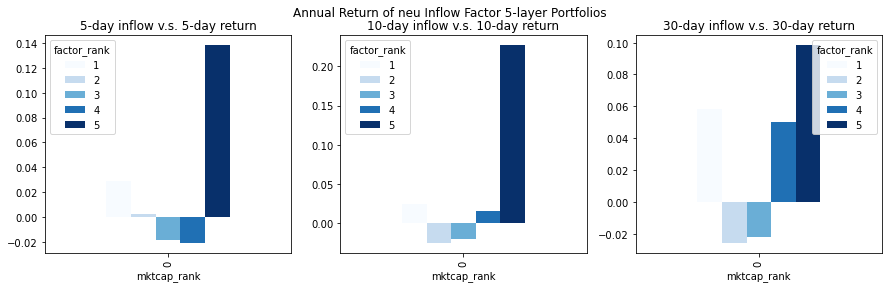

In [12]:
plot_return("neu")

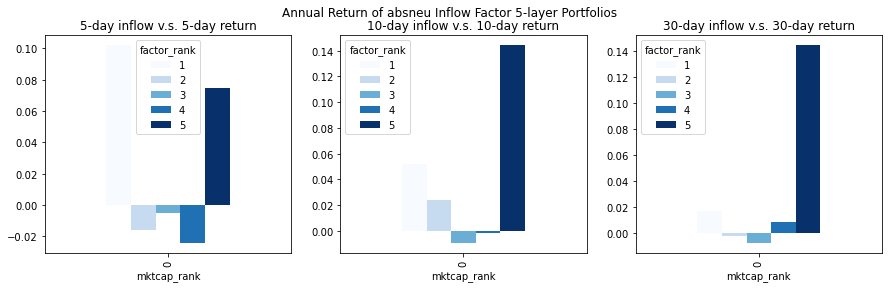

In [13]:
plot_return("absneu")

## Top and Bottom Performance
This results further suggests that information are only available at the top and bottom groups. Hence, we computed IC of the **top 10% and bottom 10%** of the pure factor and compare it with the IC of the middle group.

In [7]:
table = summary_table("\correlations\correlation_abstails_{:d}d_v4.csv","tails")

In [5]:
table = summary_table("\correlations\correlation_absmiddle_{:d}d_v4.csv","middle")

**Finding**: As expected, the IC of the tails are much higher than the pure factor and the 5-day inflow and 10-day return group even have an IC of over 4%. The middle group have a close-to-zero IC.

Moreover, the IC decreases as we increase return calculation period from 10 to 30 days. But increasing from 5 to 10 days do bring IC improvements. Hence, 10-day return seems like an optimal horizon. Prediction power of 30-day is significantly weaker than 5- and 10-day, so we would focus on the shorter term ones later on.

# Strategy Construction

## Long-Short Portfolio and Backtests
We backtested on two horizon (5- and 10-day inflow) and 3 factors. Backtesting details are listed as follow:
- rebalance horizon: 10 days
- Portfolio construction: equally-weighted (takes top 2.5% to form long and short portfolio, each portfolio contains around 10-15 stocks)
- excluded: listed in the connect in the previous 60 days or to be delisted in the next 60 days
- liquidity requirements: average daily inflow < 1 million, close price smaller than 1 hkd and market cap larger than 5 billion
- transaction cost: 0.15% for long side, 0.25% for short side

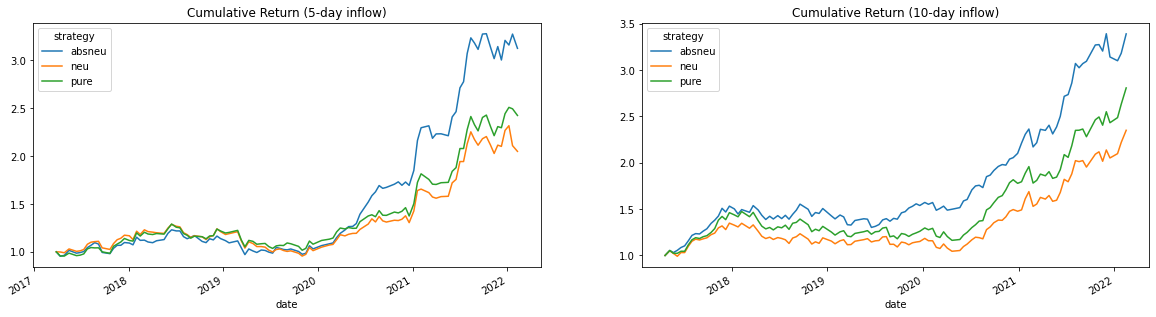

In [16]:
y, ls = plot_backtest(r'\long_short\return_v2.csv',[5,10])

In [17]:
summary_table2(ls)

,absneu,neu,pure
annualized return,26.32%,15.85%,19.91%
annualized vol,20.46%,19.70%,19.15%
sharpe ratio,128.66%,80.44%,103.98%
maximum drawdown,-21.05%,-25.73%,-21.18%
t values,288.75%,194.92%,241.72%


,absneu,neu,pure
annualized return,28.75%,19.35%,23.82%
annualized vol,16.69%,17.64%,17.96%
sharpe ratio,172.29%,109.70%,132.64%
maximum drawdown,-16.17%,-22.50%,-21.06%
t values,363.49%,247.21%,290.43%


**Finding**: In this scenario, Portfolio based on the 5-day inflow factor has smaller Sharpe ratio and higher volatility as compared to 10-day. In the 10-day group, all 3 factors generated Sharpe ratio of above 1 and the absneu factor even has a Sharpe ratio of 1.7. This suggests that the inflow factor do contain valuable information and the 10-day inflow factor is more stable and less costly compared to the 5-day inflow factor.

## Strategy Adjustment
Our backtest above uses the top 2.5% portfolio. Next we investigated the optimal percentage to construct the long-short portfolio. There are two considerations:
1. The long short portfolio should not be too large since information comes from the tail.
2. The long short portfolio should not be too small since the tails would be exposed to market cap influence and would need more diversification.

We then conduct backtest on 5% and 10% portfolio. 

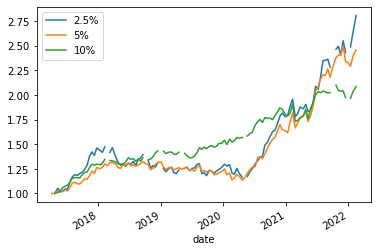

In [18]:
plot_percentage()

**Finding**: The above graph display the backtest result of the 10-day pure inflow factor. As shown, 2.5% and 5% delivered much better performance. 5% is more stable as compared to 2.5%. The other two factors also display a similar pattern. Hence, top 5% long and bottom 5% short should be an optimal setting.

Therefore, we would use top 5% as long side and bottom 5% as short side as our final trading strategy. The summary statistics of 5% portfolios are shown below. Improvement of performance is quite obvious and the 10-day absneu factor delivered a high Sharpe ratio of 1.9.

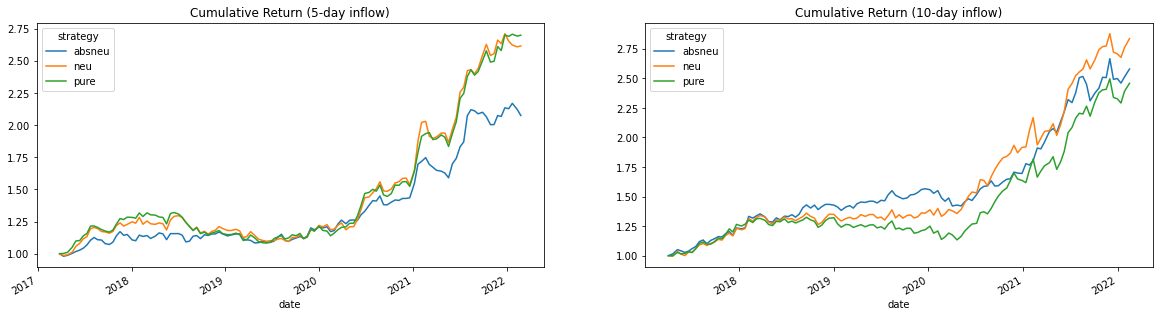

In [19]:
y, ls = plot_backtest(r'\long_short\return_v2_50.csv',[5, 10])

In [20]:
summary_table2(ls)

,absneu,neu,pure
annualized return,16.01%,21.61%,22.39%
annualized vol,12.89%,15.24%,14.12%
sharpe ratio,124.23%,141.81%,158.58%
maximum drawdown,-8.98%,-15.47%,-17.99%
t values,270.98%,303.08%,334.88%


,absneu,neu,pure
annualized return,21.44%,23.84%,20.25%
annualized vol,12.07%,14.28%,14.27%
sharpe ratio,177.66%,166.90%,141.90%
maximum drawdown,-9.31%,-10.64%,-14.44%
t values,371.29%,348.86%,303.09%


## Strategy Drawback
There are two drawbacks of the strategy:
1. the inflow factor measures capital inflow from mainland investors. **The validity of information is related to the overall investment interests of mainland investors.** As we noticed in the backtest, the 3 factors all delivers very little and even negative return in 2018 and 2019. This is likely because investment interests of mainland investors reduces during the two years after the stock market tumbles amidst the Sino-US trade war.

In [21]:
summary_tables3(y)

strategy,absneu,neu,pure
date,,,
2017,14.97%,22.83%,28.42%
2018,0.40%,-2.62%,-9.96%
2019,4.65%,2.05%,4.96%
2020,18.81%,25.97%,25.58%
2021,48.74%,76.27%,77.22%
2022,-2.79%,-3.49%,-0.07%


strategy,absneu,neu,pure
date,,,
2017,23.48%,23.14%,26.48%
2018,16.16%,9.66%,4.11%
2019,9.18%,0.66%,-7.40%
2020,8.25%,40.94%,34.20%
2021,47.36%,41.31%,42.23%
2022,3.23%,4.80%,5.62%


2. the strategies **may not deliver stable return**. We conducted backtests with different start dates and found that not all could deliver satisfying performance. The following tables show the summary statistics across backtests starting from different dates. The Sharpe ratio could range from 0.9 to 1.9, suggesting the high sensitivity of the strategy. 

Among the 3 factors, the neu inflow factor has the highest sharpe ratio even for its minimum sharpe ratio case. Its maximum drawdown is also smaller than the other two strategy. So this strategy is more recommended in terms of stability.

In [22]:
file = r'\long_short\return_v5.csv'
path = r'C:\Users\arizonazhang\OneDrive - hkaift\research\capflow'
df = pd.read_csv(path + file, index_col = 0)
df.loc[df.strategy == "delta","strategy"] = "pure"
df = df.set_index("date")
df.index = pd.to_datetime(df.index)
for s in ["pure","neu","absneu"]:
    #df[(df.n==10)&(df.strategy==s)].pivot(columns = "lag", values = "M").plot(title = 'backtests: {}'.format(s),style = '.', figsize= (20,10))
    cum = df[(df.n==10)&(df.strategy==s)].pivot(columns = "lag", values = "M")
    ret = df[(df.n==10)&(df.strategy==s)].pivot(columns = "lag", values = "net_ret")
    ls = []
    ls.append(cum.apply(total_ret))
    ls.append(cum.apply(annual_ret))
    ls.append(ret.apply(vol))
    ls.append(cum.apply(mdd))
    ls.append(ret.apply(tvalue))
    y = []
    df1 = pd.concat(ls, axis = 1)
    df1.columns = ["cum ret", "annual ret", "annual vol", "mdd", "t-value"]
    df1["sharpe"] = df1["annual ret"]/df1["annual vol"]
    #display(df1.T.style.set_caption("summary table: {}".format(s)))
    display(df1.T.agg(["max", "median", "min"], axis = 1).style.format('{:.2%}').set_caption("Summary Stats: {}".format(s)))

,max,median,min
cum ret,302.52%,279.70%,183.17%
annual ret,25.40%,23.41%,13.17%
annual vol,15.32%,14.16%,13.85%
mdd,-9.98%,-15.41%,-21.45%
t-value,375.23%,344.86%,212.36%
sharpe,180.24%,163.96%,94.23%


,max,median,min
cum ret,310.07%,293.70%,219.13%
annual ret,26.04%,24.65%,17.40%
annual vol,15.27%,14.62%,13.90%
mdd,-9.64%,-13.12%,-15.27%
t-value,377.12%,348.81%,254.87%
sharpe,181.10%,166.21%,116.12%


,max,median,min
cum ret,279.46%,237.80%,171.17%
annual ret,23.39%,19.37%,11.62%
annual vol,14.25%,12.99%,11.99%
mdd,-8.35%,-13.26%,-22.51%
t-value,376.35%,304.84%,192.50%
sharpe,180.67%,141.72%,84.31%


# Conclusion

We investigated the inflow factor's effect in stock selection and found that the stocks with large inflow and outflow contain a valuable information in generating good return. In addition, two factors constructed based on this factor through neutralizing market cap exposure are also found to have alpha. 

Our strategy long the stocks ranking in the top 5% of factor values and short the stocks of the bottom 5% of the factor values. The strategies of the 3 factors all generated a Sharpe ratio of 1.7, displaying good market timing ability.